In [68]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')
import base64
import io
from functools import reduce

## Preprocessing

In [69]:
# read in the csv files
movies = pd.read_csv('../dataset/tmdb_5000_movies.csv')
credits = pd.read_csv('../dataset/tmdb_5000_credits.csv')

# Clean the dataset by converting json columns into list of strings
fields = ['genres', 'keywords', 'production_companies', 'production_countries']
for field in fields:
    movies[field]=movies[field].apply(json.loads)
    for index,i in zip(movies.index,movies[field]):
        list1=[]
        for j in range(len(i)):
            list1.append((i[j]['name']))
        movies.loc[index,field]=str(list1)
        
        
# Clean the credits 
credits['cast']=credits['cast'].apply(json.loads)
for index,i in zip(credits.index,credits['cast']):
    list1=[]
    for j in range(len(i)):
        list1.append((i[j]['name']))
    credits.loc[index,'cast']=str(list1)

fields = ['crew']
for field in fields:
    credits[field] = credits[field].apply(json.loads)
    def director(x):
        for i in x:
            if i['job'] == 'Director':
                return i['name']
    credits['crew'] = credits['crew'].apply(director)
    credits.rename(columns={'crew':'director'},inplace=True)
    
# Need to combine two datasets. Can join on movie_id
df = pd.merge(movies, credits, how='left', left_on='id', right_on='movie_id')

# Feature engineering! select which ones we want here...
features = ['id', 'original_title', 'genres', 'cast', 'vote_average', 'director', 'keywords', 'popularity', 'vote_count']
df = df[features]

# Format genres
df['genres'] = df['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('Adventure', 'Adv').str.replace('u', '').str.replace('Adv', 'Adventure')
df['genres'] = df['genres'].str.split(',')

# Create an ordered list of all possible genres so we can use a bit string to represent them
genreList = []
for genres in df['genres']:
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
            
genreList.sort()
genreList = genreList[1:]

# Create the bitstring of genres
def genre_bitlist(genres):
    blist = []
    for genre in genreList:
        if genre in genres:
            blist.append(1)
        else:
            blist.append(0)
    return blist

            
df['genres_bs'] = df['genres'].apply(lambda x: genre_bitlist(x))

# Format the cast
df['cast']=df['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
df['cast']=df['cast'].str.split(',')

# Create a list of actors
import operator 
actorList = []
list1 = []
for i in df['cast']:
    list1.extend(i)
    
actors = {}
for actor in list1:
    if actor in actors:
        actors[actor] += 1
    else:
        actors[actor] = 1
        
sorted_actors = sorted(actors.items(), key=operator.itemgetter(1))

for i in range(0, 21):
    actorList.append(sorted_actors[-1-i])
    

actorList = [actor[0] for actor in actorList]
alist = []
for actor in actorList:
    if actor != 'r.': # Get rid of this trailing value
        alist.append(actor)
actorList = alist

# Now we need to sort the list!
actorList = sorted(actorList)
actorList = actorList[1:]

# Create the bitstring of actors
def actor_bitlist(actors):
    blist = []
    for actor in actorList:
        if actor in actors:
            blist.append(1)
        else:
            blist.append(0)
    return blist

df['cast_bs'] = df['cast'].apply(lambda x: actor_bitlist(x))

# Now directors
def isnull(s):
    if s is None:
        return ''
    return s

df['director'] = df['director'].apply(isnull)

# Create a list of directors
directorList = []
for director in df['director']:
    if director not in directorList:
        directorList.append(director)
        
directorList = sorted(directorList)[1:]

# Create the bitstring of directors
def director_bitlist(directors):
    blist = []
    for director in directorList:
        if director in directors:
            blist.append(1)
        else:
            blist.append(0)
    return blist

df['director_bs'] = df['director'].apply(lambda x: director_bitlist(x))

# Allows us to make each genre a category in the dataframe
from collections import defaultdict
cols = defaultdict(list)
for g in genreList:
    for index, row in df.iterrows():
        genres = row["genres"]
        if g in genres:
            cols[g].append(1)
        else:
            cols[g].append(0)
        
    df[g] = cols[g]
    
# Allows us to make each actor a category in the dataframe
from collections import defaultdict
cols = defaultdict(list)
for a in actorList:
    for index, row in df.iterrows():
        cast = row["cast"]
        if a in cast:
            cols[a].append(1)
        else:
            cols[a].append(0)
        
    df[a] = cols[a]

## Model Processing

In [70]:
# finalize features for models
final_features = ['popularity',  'vote_count', 'Action', 'Adventure', 'Animation', 'Comedy', 'Docmentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Mystery', 'Romance', 'ScienceFiction', 'Thriller', 'War', 'Western', 'AlecBaldwin', 'BradPitt', 'BruceWillis', 'JohnGoodman', 'JohnnyDepp', 'LiamNeeson', 'MattDamon', 'MorganFreeman', 'NicolasCage', 'OwenWilson', 'RobertDeNiro', 'SamuelL.Jackson', 'SteveBuscemi', 'WillFerrell', 'WillemDafoe']
target = ['vote_average']

X = df[final_features]
Y = df[target]

In [120]:
# data frame to store all results
results = pd.DataFrame()

In [152]:
# Lin Reg

from sklearn import linear_model
from sklearn.model_selection import cross_validate


test_scores = []
train_scores = []
for i in range(10):
    # Specify that we want to use mean_squared error for the cross-validation
    new_df = df.sample(frac=1)
    new_X = new_df[final_features]
    new_Y = new_df[target]

    lin = linear_model.LinearRegression()
    cv_results = cross_validate(lin, X, Y, cv=10, scoring='neg_mean_squared_error')
    
    test_score = abs(cv_results['test_score'])
    train_score = abs(cv_results['train_score'])
    
    test_scores = np.append(test_score, test_scores)
    train_scores = np.append(train_score, train_scores)

results['lin'] = test_scores

In [180]:
# PCA Lin Reg

from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate

test_scores = []
train_scores = []
for i in range(10):
    # Specify that we want to use mean_squared error for the cross-validation
    new_df = df.sample(frac=1)
    new_X = new_df[final_features]
    new_Y = new_df[target]
    
    lin = linear_model.LinearRegression()
    
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(new_X)
    pca_cv_results = cross_validate(lin, pca_data, Y, cv=10, scoring='neg_mean_squared_error')
    
    test_score = abs(pca_cv_results['test_score'])
    train_score = abs(pca_cv_results['train_score'])
    
    test_scores = np.append(test_score, test_scores)
    train_scores = np.append(train_score, train_scores)

results['pca_lin'] = test_scores

In [204]:
#Decision Tree

from sklearn.tree import DecisionTreeRegressor

test_scores = []
train_scores = []
for i in range(10):
    # Specify that we want to use mean_squared error for the cross-validation
    new_df = df.sample(frac=1)
    new_X = new_df[final_features]
    new_Y = new_df[target]

    dt = DecisionTreeRegressor(random_state=0)
    cv_results = cross_validate(dt, X, Y, cv=10, scoring='neg_mean_squared_error')
    
    test_score = abs(cv_results['test_score'])
    train_score = abs(cv_results['train_score'])
    
    test_scores = np.append(test_score, test_scores)
    train_scores = np.append(train_score, train_scores)

results['dt'] = test_scores

In [122]:
# Gaussian Process

import pyGPs

test_scores = []

for i in range(10):
    
    new_df = df.sample(frac=1)
    new_X = new_df[final_features]
    new_Y = new_df[target]
    
    k1, k2, k3, k4, k5, k6, k7, k8, k9, k10 = pyGPs.Validation.valid.k_fold_validation(new_X, new_Y, K=10, randomise=True)
    k_folds = [k1, k2, k3, k4, k5, k6, k7, k8, k9, k10]

    kernel1 = pyGPs.cov.RBF(log_ell=math.log(1/math.sqrt(2)), log_sigma=math.log(1))
    
    oos_y1 = []
    oos_pred1 = []
    meanNLPD = 0
    meanRMSE = 0

    for i, k in enumerate(k_folds):
        x_train, x_test, y_train, y_test = k

        model = pyGPs.GPR()
        model.setPrior(mean=pyGPs.mean.Const(6.09), kernel=kernel1)
        nlz, post = model.getPosterior(x_train, y_train, False)
        model.predict(x_test)

        oos_y1.append(y_test)
        oos_pred1.append(model.ym)        

        # Measure this fold's accuracy
        nlpd = np.mean(0.5*np.log(2*math.pi*model.ys2) + 0.5*((y_test - model.ym)**2)/model.ys2)
        rmse = pyGPs.Validation.valid.RMSE(model.ym, y_test)
#         print("Fold", str(i) + ":", " NLPD: {}".format(nlpd), " RMSE: {}".format(rmse))
        test_scores.append(rmse**2)

results['gp'] = test_scores

In [ ]:
# SVM

from sklearn import svm
from sklearn.model_selection import cross_validate

test_scores = []
train_scores = []
for i in range(10):
    print(i)
    # Specify that we want to use mean_squared error for the cross-validation
    new_df = df.sample(frac=1)
    new_X = new_df[final_features]
    new_Y = new_df[target]

    clf = svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)    
    cv_results = cross_validate(clf, X, Y, cv=10, scoring='neg_mean_squared_error')
    
    test_score = abs(cv_results['test_score'])
    train_score = abs(cv_results['train_score'])
    
    test_scores = np.append(test_score, test_scores)
    train_scores = np.append(train_score, train_scores)

results['svm'] = test_scores

In [211]:
# PCA SVM

from sklearn import svm
from sklearn.model_selection import cross_validate

test_scores = []
train_scores = []
for i in range(10):
    # Specify that we want to use mean_squared error for the cross-validation
    new_df = df.sample(frac=1)
    new_X = new_df[final_features]
    new_Y = new_df[target]

    clf = svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)    
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(new_X)
    pca_cv_results = cross_validate(clf, pca_data, Y, cv=10, scoring='neg_mean_squared_error')
    
    test_score = abs(pca_cv_results['test_score'])
    train_score = abs(pca_cv_results['train_score'])
    
    test_scores = np.append(test_score, test_scores)
    train_scores = np.append(train_score, train_scores)


results['pca_svm'] = test_scores

## Analysis of Results

Text(0,0.5,'Mean Squared Error')

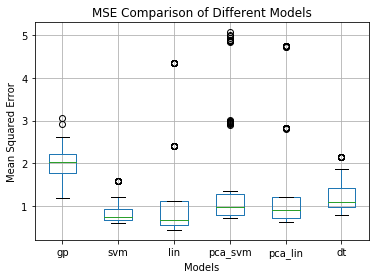

In [207]:
# boxplot of model distributions

plt.figure()
boxplot = results.boxplot()
plt.title("MSE Comparison of Different Models")
plt.xlabel("Models")
plt.ylabel("Mean Squared Error")

In [218]:
# summary statistics of models
results.describe()

,gp,svm,lin,pca_svm,pca_lin,dt
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.017651,0.869469,1.239129,1.541495,1.438918,1.246030
std,0.327001,0.295513,1.177144,1.294658,1.265256,0.415646
min,1.183683,0.597884,0.437462,0.717294,0.620877,0.799459
25%,1.770453,0.678932,0.549132,0.783331,0.709556,0.979354
50%,2.021073,0.753422,0.682087,0.975039,0.896420,1.084209
75%,2.226772,0.929300,1.114039,1.278159,1.212082,1.424729
max,3.059711,1.587310,4.343920,5.070399,4.745998,2.137667


In [210]:
# Use t-test to find pvalue (assume normal as sample size>30)
# Analyzing pvalues to see if SVM is significantly different than others 

from scipy.stats import ttest_ind, f_oneway

value, pvalue = ttest_ind(results['svm'], results['lin'], equal_var=False)
print("pvalue of SVM vs LR:", pvalue)
value, pvalue = ttest_ind(results['svm'], results['pca_lin'], equal_var=False)
print("pvalue of SVM vs PCA LR:", pvalue)
value, pvalue = ttest_ind(results['svm'], results['pca_svm'], equal_var=False)
print("pvalue of SVM vs PCA SVM:", pvalue)
value, pvalue = ttest_ind(results['svm'], results['gp'], equal_var=False)
print("pvalue of SVM vs GP:", pvalue)
value, pvalue = ttest_ind(results['svm'], results['dt'], equal_var=False)
print("pvalue of SVM vs DT:", pvalue)

pvalue of SVM vs LR: 0.00289690006472
pvalue of SVM vs PCA LR: 2.69496327436e-05
pvalue of SVM vs PCA SVM: 1.70185045279e-06
pvalue of SVM vs GP: 1.41447072056e-65
pvalue of SVM vs DT: 5.63422099612e-12
